In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from encoding_information.gpu_utils import limit_gpu_memory_growth
# limit_gpu_memory_growth()

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpy as onp
from encoding_information.image_utils import *
from encoding_information.information_estimation import *


2024-01-26 11:36:41.829186: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 11:36:42.568678: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-26 11:36:42.568894: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-26 11:36:42.568903: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
a = np.zeros(100)

In [10]:
eric_dir = '/home/emarkley/Workspace/PYTHON/InformationTheoryEndToEnd/MIMeasurements/'
folder = 'DPC_xlr0.003_ylr0.003_rlr0.005_unetlr0.0001'
filenames = [file for file in os.listdir(eric_dir + folder) if file.endswith('.npy')]
indices = [int(file.split('_')[-1].split('.')[0]) for file in filenames]
# sort by index
filenames = [x for _,x in sorted(zip(indices,filenames))]

# load data for each
data = []
for file in filenames:
    data.append(np.load(eric_dir + folder + '/' + file))
print(filenames)

(1500, 100, 100)
523.0329833199277 523.0171378218295


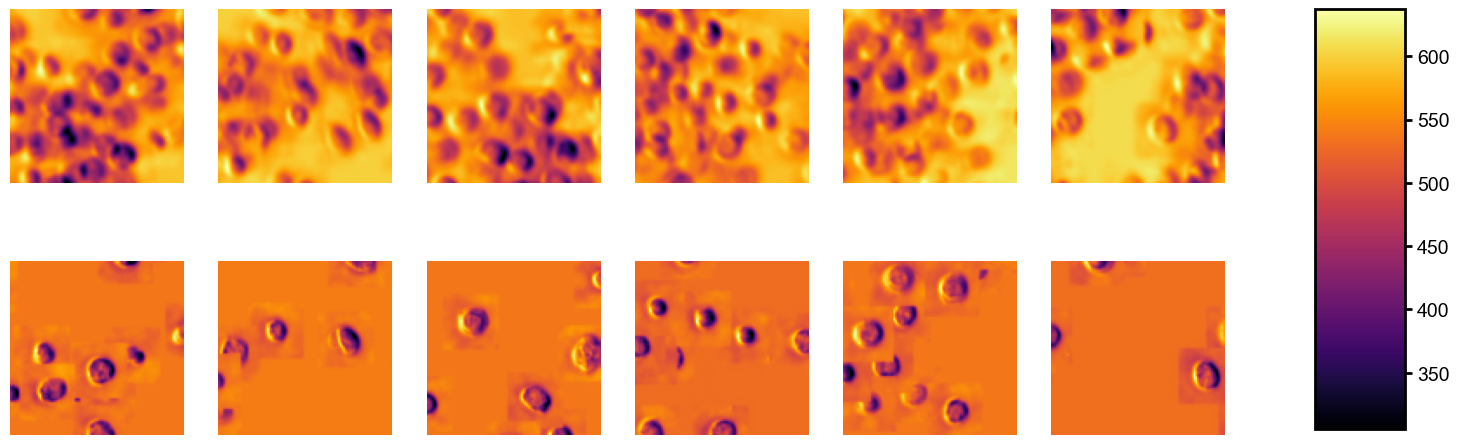

In [ ]:
num_plots = 6

initial_clean_data = data[0]
final_clean_data = data[-1]

# find shared vmin and vmax from both datasets
vmin = np.min(np.concatenate([initial_clean_data, final_clean_data]))
vmax = np.max(np.concatenate([initial_clean_data, final_clean_data]))


fig, axes = plt.subplots(2, num_plots, figsize=(3 * num_plots,6))
for i, ax in enumerate(axes.T):
    ax[0].imshow(initial_clean_data[i], cmap='inferno')
    ax[0].axis('off')
    im = ax[1].imshow(final_clean_data[i], cmap='inferno')
    ax[1].axis('off')

# show shared colorbar on right side
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

print (initial_clean_data.shape)
print(initial_clean_data.mean(), final_clean_data.mean())

Text(0.5, 1.0, 'Noisy Data')

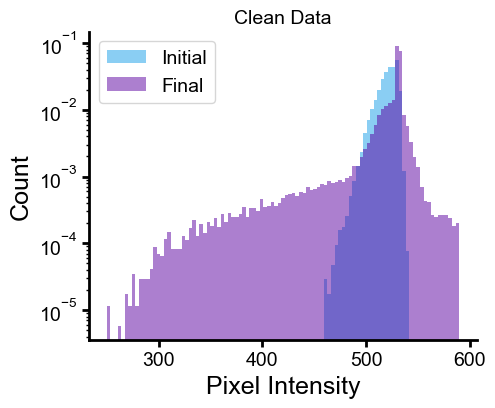

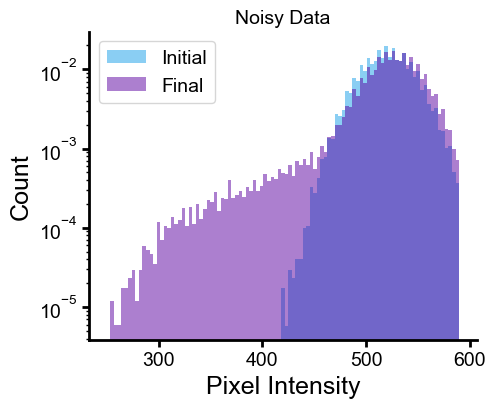

In [ ]:
# plot histogram of clean patches
fig, ax = plt.subplots(1, 1, figsize=(5,4))
bins = np.linspace(min(initial_clean_data[:5].min(), final_clean_data[:5].min()),
                        max(np.percentile(initial_clean_data[:5], 99.5), np.percentile(final_clean_data[:5], 99.5)), 100)


ax.hist(initial_clean_data[:5].flatten(),  alpha=0.5, label='Initial', bins=bins, density=True, log=True)
ax.hist(final_clean_data[:5].flatten(),  alpha=0.5, label='Final', bins=bins, density=True, log=True)
ax.set_xlabel('Pixel Intensity')
ax.set_ylabel('Count')
ax.legend()
clear_spines(ax)
ax.set_title('Clean Data')


# plot histogram of noisy patches
fig, ax = plt.subplots(1, 1, figsize=(5,4))
initial_noisy_data_to_show = add_noise(data[0][:5])
final_noisy_data_to_show = add_noise(data[-1][:5])
ax.hist(initial_noisy_data_to_show.flatten(),  alpha=0.5, label='Initial', bins=bins, density=True, log=True)
ax.hist(final_noisy_data_to_show.flatten(),  alpha=0.5, label='Final', bins=bins, density=True, log=True)
ax.set_xlabel('Pixel Intensity')
ax.set_ylabel('Count')
ax.legend()
clear_spines(ax)
ax.set_title('Noisy Data')

## Look at MI estimates vs patch size for inital and final time points

In [ ]:
patch_size_list = [10, 20, 30, 40, 50]
num_patches = 500

mi_estimates_initial = []
mi_estimates_final = []
pixel_cnns_initial = []
pixel_cnns_final = []
for patch_size in tqdm(patch_size_list):
    clean_patches_initial = extract_patches(initial_clean_data, patch_size, num_patches)
    noisy_patches_initial = add_noise(clean_patches_initial)
    mi, pixel_cnn = estimate_mutual_information(noisy_patches_initial, clean_images=clean_patches_initial, entropy_model='pixel_cnn', max_epochs=50, return_entropy_model=True, verbose=True)
    mi_estimates_initial.append(mi)

    clean_patches_final = extract_patches(final_clean_data, patch_size, num_patches)
    noisy_patches_final = add_noise(clean_patches_final)
    mi, pixel_cnn = estimate_mutual_information(noisy_patches_final, clean_images=clean_patches_final, entropy_model='pixel_cnn', max_epochs=50, return_entropy_model=True, verbose=True)
    mi_estimates_final.append(mi)

  0%|          | 0/5 [00:00<?, ?it/s]

/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/image_distribution_models.py:187: UserWarning: Number of validation samples must be less than the number of training samples. Using 45 validation samples instead.
  warnings.warn(f'Number of validation samples must be less than the number of training samples. Using {num_val_samples} validation samples instead.')


Initial validation NLL: 10.51


Epoch 1: 100%|██████████| 100/100 [00:06<00:00, 15.46it/s]


Epoch 1: validation NLL: 4.58


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 88.58it/s]


Epoch 2: validation NLL: 4.59


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 96.82it/s]


Epoch 3: validation NLL: 4.78


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 87.76it/s]


Epoch 4: validation NLL: 5.28


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 97.95it/s]


Epoch 5: validation NLL: 6.14


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 80.32it/s]


Epoch 6: validation NLL: 6.85


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 89.46it/s]


Epoch 7: validation NLL: 6.79


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 89.98it/s]


Epoch 8: validation NLL: 7.12


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 82.39it/s]


Epoch 9: validation NLL: 7.45


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 87.82it/s]


Epoch 10: validation NLL: 7.57


Epoch 11: 100%|██████████| 100/100 [00:01<00:00, 83.59it/s]


Epoch 11: validation NLL: 7.53
Estimated H(Y|X) = 4.549 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.583 differential entropy/pixel
Estimated I(Y;X) = 0.049 bits/pixel
Initial validation NLL: 33.37


: 

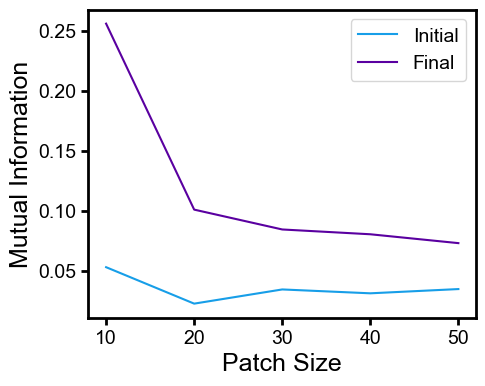

In [ ]:
# plot mutual information estimates

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.plot(patch_size_list, mi_estimates_initial, label='Initial')
ax.plot(patch_size_list, mi_estimates_final, label='Final')
ax.set_xlabel('Patch Size')
ax.set_ylabel('Mutual Information')
ax.legend()

## Generate MI estimate vs iteration in end to end training

In [ ]:
patch_size = 40
num_patches = 1000

mi_estimates = []
pixel_cnns = []
for images in tqdm(data):
    clean_patches = extract_patches(images, patch_size, num_patches)
    noisy_patches = add_noise(clean_patches)
    mi, pixel_cnn = estimate_mutual_information(noisy_patches, clean_images=clean_patches, 
                                                entropy_model='pixel_cnn', max_epochs=50, return_entropy_model=True, verbose=True)
    mi_estimates.append(mi)


  0%|          | 0/21 [00:00<?, ?it/s]2023-12-07 13:09:25.427733: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Initial validation NLL: 13.40


Epoch 1: 100%|██████████| 100/100 [00:20<00:00,  4.82it/s]


Epoch 1: validation NLL: 4.57


Epoch 2: 100%|██████████| 100/100 [00:06<00:00, 15.89it/s]


Epoch 2: validation NLL: 4.57


Epoch 3: 100%|██████████| 100/100 [00:06<00:00, 16.32it/s]


Epoch 3: validation NLL: 4.57


Epoch 4: 100%|██████████| 100/100 [00:06<00:00, 16.31it/s]


Epoch 4: validation NLL: 4.57


Epoch 5: 100%|██████████| 100/100 [00:06<00:00, 16.58it/s]


Epoch 5: validation NLL: 4.57


Epoch 6: 100%|██████████| 100/100 [00:06<00:00, 16.06it/s]


Epoch 6: validation NLL: 4.57


Epoch 7: 100%|██████████| 100/100 [00:06<00:00, 16.46it/s]


Epoch 7: validation NLL: 4.57


Epoch 8: 100%|██████████| 100/100 [00:06<00:00, 16.13it/s]


Epoch 8: validation NLL: 4.57


Epoch 9: 100%|██████████| 100/100 [00:06<00:00, 16.56it/s]


Epoch 9: validation NLL: 4.57


Epoch 10: 100%|██████████| 100/100 [00:06<00:00, 16.29it/s]


Epoch 10: validation NLL: 4.58


Epoch 11: 100%|██████████| 100/100 [00:06<00:00, 16.49it/s]


Epoch 11: validation NLL: 4.59


Epoch 12: 100%|██████████| 100/100 [00:06<00:00, 16.29it/s]


Epoch 12: validation NLL: 4.60


Epoch 13: 100%|██████████| 100/100 [00:06<00:00, 16.21it/s]


Epoch 13: validation NLL: 4.61


Epoch 14: 100%|██████████| 100/100 [00:06<00:00, 16.50it/s]


Epoch 14: validation NLL: 4.63


2023-12-07 13:11:18.739537: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-12-07 13:11:18.739560: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[32,128,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f64[32,64,40,40]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-12-07 13:11:23.567063: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-12-07 13:11:23.567097: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[32,128,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f64[32,64,40,40]{3,2,1,0}, f64[128,64,1,3]{3,2,1,0}, f64[128]{0}, 

Estimated H(Y|X) = 4.549 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.569 differential entropy/pixel
Estimated I(Y;X) = 0.028 bits/pixel
Initial validation NLL: 14.39


Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.57it/s]


Epoch 1: validation NLL: 4.58


Epoch 2: 100%|██████████| 100/100 [00:06<00:00, 16.19it/s]


Epoch 2: validation NLL: 4.57


Epoch 3: 100%|██████████| 100/100 [00:06<00:00, 16.04it/s]


Epoch 3: validation NLL: 4.57


Epoch 4: 100%|██████████| 100/100 [00:06<00:00, 16.53it/s]


Epoch 4: validation NLL: 4.57


Epoch 5: 100%|██████████| 100/100 [00:06<00:00, 16.27it/s]


Epoch 5: validation NLL: 4.57


Epoch 6: 100%|██████████| 100/100 [00:06<00:00, 16.20it/s]


Epoch 6: validation NLL: 4.57


Epoch 7: 100%|██████████| 100/100 [00:06<00:00, 16.51it/s]


Epoch 7: validation NLL: 4.57


Epoch 8: 100%|██████████| 100/100 [00:06<00:00, 16.19it/s]


Epoch 8: validation NLL: 4.57


Epoch 9: 100%|██████████| 100/100 [00:06<00:00, 16.36it/s]


Epoch 9: validation NLL: 4.57


Epoch 10: 100%|██████████| 100/100 [00:06<00:00, 16.44it/s]


Epoch 10: validation NLL: 4.58


Epoch 11: 100%|██████████| 100/100 [00:06<00:00, 16.47it/s]


Epoch 11: validation NLL: 4.57


Epoch 12: 100%|██████████| 100/100 [00:06<00:00, 16.32it/s]


Epoch 12: validation NLL: 4.58


Epoch 13: 100%|██████████| 100/100 [00:06<00:00, 16.27it/s]


Epoch 13: validation NLL: 4.58


Epoch 14: 100%|██████████| 100/100 [00:06<00:00, 16.32it/s]


Epoch 14: validation NLL: 4.58


Epoch 15: 100%|██████████| 100/100 [00:06<00:00, 16.12it/s]


Epoch 15: validation NLL: 4.59


Epoch 16: 100%|██████████| 100/100 [00:06<00:00, 16.36it/s]


Epoch 16: validation NLL: 4.61


 10%|▉         | 2/21 [04:21<40:37, 128.30s/it]

Estimated H(Y|X) = 4.549 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.570 differential entropy/pixel
Estimated I(Y;X) = 0.031 bits/pixel
Initial validation NLL: 13.84


Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.80it/s]


Epoch 1: validation NLL: 4.58


Epoch 2: 100%|██████████| 100/100 [00:06<00:00, 15.86it/s]


Epoch 2: validation NLL: 4.58


Epoch 3: 100%|██████████| 100/100 [00:06<00:00, 16.35it/s]


Epoch 3: validation NLL: 4.57


Epoch 4: 100%|██████████| 100/100 [00:06<00:00, 16.45it/s]


Epoch 4: validation NLL: 4.57


Epoch 5: 100%|██████████| 100/100 [00:06<00:00, 16.12it/s]


Epoch 5: validation NLL: 4.57


Epoch 6: 100%|██████████| 100/100 [00:06<00:00, 16.46it/s]


Epoch 6: validation NLL: 4.57


Epoch 7: 100%|██████████| 100/100 [00:06<00:00, 16.33it/s]


Epoch 7: validation NLL: 4.57


Epoch 8: 100%|██████████| 100/100 [00:06<00:00, 16.33it/s]


Epoch 8: validation NLL: 4.57


Epoch 9: 100%|██████████| 100/100 [00:06<00:00, 16.49it/s]


Epoch 9: validation NLL: 4.58


Epoch 10: 100%|██████████| 100/100 [00:06<00:00, 16.33it/s]


Epoch 10: validation NLL: 4.58


Epoch 11: 100%|██████████| 100/100 [00:06<00:00, 16.57it/s]


Epoch 11: validation NLL: 4.58


Epoch 12: 100%|██████████| 100/100 [00:06<00:00, 16.14it/s]


Epoch 12: validation NLL: 4.59


Epoch 13: 100%|██████████| 100/100 [00:06<00:00, 16.27it/s]


Epoch 13: validation NLL: 4.60


Epoch 14: 100%|██████████| 100/100 [00:06<00:00, 16.18it/s]


Epoch 14: validation NLL: 4.60


 14%|█▍        | 3/21 [06:05<35:04, 116.91s/it]

Estimated H(Y|X) = 4.549 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.571 differential entropy/pixel
Estimated I(Y;X) = 0.032 bits/pixel
Initial validation NLL: 14.13


Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.98it/s]


Epoch 1: validation NLL: 4.57


Epoch 2: 100%|██████████| 100/100 [00:06<00:00, 16.27it/s]


Epoch 2: validation NLL: 4.57


Epoch 3: 100%|██████████| 100/100 [00:06<00:00, 16.46it/s]


Epoch 3: validation NLL: 4.57


Epoch 4: 100%|██████████| 100/100 [00:06<00:00, 15.93it/s]


Epoch 4: validation NLL: 4.57


Epoch 5: 100%|██████████| 100/100 [00:06<00:00, 16.51it/s]


Epoch 5: validation NLL: 4.57


Epoch 6: 100%|██████████| 100/100 [00:06<00:00, 16.09it/s]


Epoch 6: validation NLL: 4.57


Epoch 7: 100%|██████████| 100/100 [00:06<00:00, 16.36it/s]


Epoch 7: validation NLL: 4.57


Epoch 8: 100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


Epoch 8: validation NLL: 4.57


Epoch 9: 100%|██████████| 100/100 [00:06<00:00, 16.34it/s]


Epoch 9: validation NLL: 4.57


Epoch 10: 100%|██████████| 100/100 [00:06<00:00, 16.41it/s]


Epoch 10: validation NLL: 4.57


Epoch 11: 100%|██████████| 100/100 [00:06<00:00, 16.02it/s]


Epoch 11: validation NLL: 4.58


Epoch 12: 100%|██████████| 100/100 [00:06<00:00, 16.40it/s]


Epoch 12: validation NLL: 4.58


Epoch 13: 100%|██████████| 100/100 [00:06<00:00, 16.13it/s]


Epoch 13: validation NLL: 4.59


Epoch 14: 100%|██████████| 100/100 [00:06<00:00, 16.29it/s]


Epoch 14: validation NLL: 4.60


Epoch 15: 100%|██████████| 100/100 [00:06<00:00, 16.37it/s]


Epoch 15: validation NLL: 4.61


Epoch 16: 100%|██████████| 100/100 [00:06<00:00, 16.00it/s]


Epoch 16: validation NLL: 4.62


 19%|█▉        | 4/21 [08:01<33:01, 116.54s/it]

Estimated H(Y|X) = 4.549 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.577 differential entropy/pixel
Estimated I(Y;X) = 0.041 bits/pixel
Initial validation NLL: 25.88


Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.54it/s]


Epoch 1: validation NLL: 4.64


Epoch 2: 100%|██████████| 100/100 [00:06<00:00, 16.28it/s]


Epoch 2: validation NLL: 4.64


Epoch 3: 100%|██████████| 100/100 [00:06<00:00, 16.22it/s]


Epoch 3: validation NLL: 4.63


Epoch 4: 100%|██████████| 100/100 [00:06<00:00, 16.29it/s]


Epoch 4: validation NLL: 4.63


Epoch 5: 100%|██████████| 100/100 [00:06<00:00, 16.19it/s]


Epoch 5: validation NLL: 4.62


Epoch 6: 100%|██████████| 100/100 [00:06<00:00, 16.37it/s]


Epoch 6: validation NLL: 4.63


Epoch 7: 100%|██████████| 100/100 [00:06<00:00, 16.47it/s]


Epoch 7: validation NLL: 4.63


Epoch 8: 100%|██████████| 100/100 [00:06<00:00, 16.13it/s]


Epoch 8: validation NLL: 4.63


Epoch 9: 100%|██████████| 100/100 [00:06<00:00, 16.26it/s]


Epoch 9: validation NLL: 4.63


Epoch 10: 100%|██████████| 100/100 [00:06<00:00, 16.12it/s]


Epoch 10: validation NLL: 4.63


Epoch 11: 100%|██████████| 100/100 [00:06<00:00, 16.24it/s]


Epoch 11: validation NLL: 4.63


Epoch 12: 100%|██████████| 100/100 [00:06<00:00, 16.55it/s]


Epoch 12: validation NLL: 4.63


Epoch 13: 100%|██████████| 100/100 [00:06<00:00, 16.44it/s]


Epoch 13: validation NLL: 4.63


Epoch 14: 100%|██████████| 100/100 [00:06<00:00, 16.27it/s]


Epoch 14: validation NLL: 4.63


Epoch 15: 100%|██████████| 100/100 [00:06<00:00, 15.97it/s]


Epoch 15: validation NLL: 4.63


 24%|██▍       | 5/21 [09:51<30:26, 114.17s/it]

Estimated H(Y|X) = 4.548 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.621 differential entropy/pixel
Estimated I(Y;X) = 0.105 bits/pixel
Initial validation NLL: 50.81


Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.61it/s]


Epoch 1: validation NLL: 4.75


Epoch 2: 100%|██████████| 100/100 [00:06<00:00, 16.34it/s]


Epoch 2: validation NLL: 4.65


Epoch 3: 100%|██████████| 100/100 [00:06<00:00, 16.63it/s]


Epoch 3: validation NLL: 4.63


Epoch 4: 100%|██████████| 100/100 [00:06<00:00, 16.27it/s]


Epoch 4: validation NLL: 4.62


Epoch 5: 100%|██████████| 100/100 [00:06<00:00, 16.20it/s]


Epoch 5: validation NLL: 4.61


Epoch 6: 100%|██████████| 100/100 [00:06<00:00, 16.38it/s]


Epoch 6: validation NLL: 4.61


Epoch 7: 100%|██████████| 100/100 [00:06<00:00, 16.06it/s]


Epoch 7: validation NLL: 4.61


Epoch 8: 100%|██████████| 100/100 [00:06<00:00, 16.37it/s]


Epoch 8: validation NLL: 4.61


Epoch 9: 100%|██████████| 100/100 [00:06<00:00, 16.39it/s]


Epoch 9: validation NLL: 4.61


Epoch 10: 100%|██████████| 100/100 [00:06<00:00, 16.41it/s]


Epoch 10: validation NLL: 4.61


Epoch 11: 100%|██████████| 100/100 [00:06<00:00, 16.38it/s]


Epoch 11: validation NLL: 4.61


Epoch 12: 100%|██████████| 100/100 [00:06<00:00, 16.12it/s]


Epoch 12: validation NLL: 4.60


Epoch 13: 100%|██████████| 100/100 [00:06<00:00, 16.25it/s]


Epoch 13: validation NLL: 4.60


Epoch 14: 100%|██████████| 100/100 [00:06<00:00, 16.20it/s]


Epoch 14: validation NLL: 4.60


Epoch 15: 100%|██████████| 100/100 [00:06<00:00, 16.33it/s]


Epoch 15: validation NLL: 4.61


Epoch 16: 100%|██████████| 100/100 [00:06<00:00, 16.47it/s]


Epoch 16: validation NLL: 4.61


Epoch 17: 100%|██████████| 100/100 [00:06<00:00, 16.04it/s]


Epoch 17: validation NLL: 4.61


Epoch 18: 100%|██████████| 100/100 [00:06<00:00, 16.33it/s]


Epoch 18: validation NLL: 4.61


Epoch 19: 100%|██████████| 100/100 [00:06<00:00, 16.00it/s]


Epoch 19: validation NLL: 4.61


Epoch 20: 100%|██████████| 100/100 [00:06<00:00, 15.97it/s]


Epoch 20: validation NLL: 4.62


Epoch 21: 100%|██████████| 100/100 [00:06<00:00, 15.98it/s]


Epoch 21: validation NLL: 4.62


Epoch 22: 100%|██████████| 100/100 [00:06<00:00, 16.41it/s]


Epoch 22: validation NLL: 4.63


Epoch 23: 100%|██████████| 100/100 [00:06<00:00, 16.02it/s]


Epoch 23: validation NLL: 4.63


 29%|██▊       | 6/21 [12:30<32:23, 129.60s/it]

Estimated H(Y|X) = 4.548 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.608 differential entropy/pixel
Estimated I(Y;X) = 0.087 bits/pixel
Initial validation NLL: 36.42


Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.73it/s]


Epoch 1: validation NLL: 4.63


Epoch 2: 100%|██████████| 100/100 [00:06<00:00, 15.67it/s]


Epoch 2: validation NLL: 4.61


Epoch 3: 100%|██████████| 100/100 [00:06<00:00, 16.39it/s]


Epoch 3: validation NLL: 4.60


Epoch 4: 100%|██████████| 100/100 [00:06<00:00, 16.13it/s]


Epoch 4: validation NLL: 4.60


Epoch 5: 100%|██████████| 100/100 [00:06<00:00, 16.16it/s]


Epoch 5: validation NLL: 4.60


Epoch 6: 100%|██████████| 100/100 [00:06<00:00, 15.99it/s]


Epoch 6: validation NLL: 4.60


Epoch 7: 100%|██████████| 100/100 [00:06<00:00, 16.46it/s]


Epoch 7: validation NLL: 4.59


Epoch 8: 100%|██████████| 100/100 [00:06<00:00, 16.24it/s]


Epoch 8: validation NLL: 4.60


Epoch 9: 100%|██████████| 100/100 [00:06<00:00, 16.20it/s]


Epoch 9: validation NLL: 4.59


Epoch 10: 100%|██████████| 100/100 [00:06<00:00, 16.10it/s]


Epoch 10: validation NLL: 4.60


Epoch 11: 100%|██████████| 100/100 [00:06<00:00, 16.13it/s]


Epoch 11: validation NLL: 4.60


Epoch 12: 100%|██████████| 100/100 [00:06<00:00, 16.24it/s]


Epoch 12: validation NLL: 4.60


Epoch 13: 100%|██████████| 100/100 [00:06<00:00, 16.21it/s]


Epoch 13: validation NLL: 4.60


Epoch 14: 100%|██████████| 100/100 [00:06<00:00, 16.35it/s]


Epoch 14: validation NLL: 4.60


Epoch 15: 100%|██████████| 100/100 [00:06<00:00, 16.32it/s]


Epoch 15: validation NLL: 4.60


Epoch 16: 100%|██████████| 100/100 [00:06<00:00, 16.12it/s]


Epoch 16: validation NLL: 4.61


Epoch 17: 100%|██████████| 100/100 [00:06<00:00, 16.19it/s]


Epoch 17: validation NLL: 4.61


 33%|███▎      | 7/21 [14:33<29:42, 127.32s/it]

Estimated H(Y|X) = 4.548 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.592 differential entropy/pixel
Estimated I(Y;X) = 0.063 bits/pixel
Initial validation NLL: 38.61


Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.86it/s]


Epoch 1: validation NLL: 4.73


Epoch 2: 100%|██████████| 100/100 [00:06<00:00, 16.48it/s]


Epoch 2: validation NLL: 4.73


Epoch 3: 100%|██████████| 100/100 [00:06<00:00, 16.04it/s]


Epoch 3: validation NLL: 4.72


Epoch 4: 100%|██████████| 100/100 [00:06<00:00, 16.38it/s]


Epoch 4: validation NLL: 4.72


Epoch 5: 100%|██████████| 100/100 [00:06<00:00, 16.09it/s]


Epoch 5: validation NLL: 4.72


Epoch 6: 100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


Epoch 6: validation NLL: 4.72


Epoch 7: 100%|██████████| 100/100 [00:06<00:00, 16.46it/s]


Epoch 7: validation NLL: 4.72


Epoch 8: 100%|██████████| 100/100 [00:06<00:00, 16.39it/s]


Epoch 8: validation NLL: 4.71


Epoch 9: 100%|██████████| 100/100 [00:06<00:00, 16.53it/s]


Epoch 9: validation NLL: 4.72


Epoch 10: 100%|██████████| 100/100 [00:06<00:00, 15.82it/s]


Epoch 10: validation NLL: 4.72


Epoch 11: 100%|██████████| 100/100 [00:06<00:00, 16.40it/s]


Epoch 11: validation NLL: 4.72


Epoch 12: 100%|██████████| 100/100 [00:06<00:00, 16.14it/s]


Epoch 12: validation NLL: 4.71


Epoch 13: 100%|██████████| 100/100 [00:06<00:00, 16.32it/s]


Epoch 13: validation NLL: 4.72


Epoch 14: 100%|██████████| 100/100 [00:06<00:00, 16.34it/s]


Epoch 14: validation NLL: 4.72


Epoch 15: 100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


Epoch 15: validation NLL: 4.72


Epoch 16: 100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


Epoch 16: validation NLL: 4.72


Epoch 17: 100%|██████████| 100/100 [00:06<00:00, 16.14it/s]


Epoch 17: validation NLL: 4.72


Epoch 18: 100%|██████████| 100/100 [00:06<00:00, 16.38it/s]


Epoch 18: validation NLL: 4.72


Epoch 19: 100%|██████████| 100/100 [00:06<00:00, 15.98it/s]


Epoch 19: validation NLL: 4.72


Epoch 20: 100%|██████████| 100/100 [00:06<00:00, 16.35it/s]


Epoch 20: validation NLL: 4.72


Epoch 21: 100%|██████████| 100/100 [00:06<00:00, 16.41it/s]


Epoch 21: validation NLL: 4.72


Epoch 22: 100%|██████████| 100/100 [00:06<00:00, 16.09it/s]


Epoch 22: validation NLL: 4.72


 38%|███▊      | 8/21 [17:06<29:23, 135.67s/it]

Estimated H(Y|X) = 4.548 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.705 differential entropy/pixel
Estimated I(Y;X) = 0.227 bits/pixel
Initial validation NLL: 57.82


Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.72it/s]


Epoch 1: validation NLL: 4.75


Epoch 2: 100%|██████████| 100/100 [00:06<00:00, 16.34it/s]


Epoch 2: validation NLL: 4.74


Epoch 3: 100%|██████████| 100/100 [00:06<00:00, 16.37it/s]


Epoch 3: validation NLL: 4.62


Epoch 4: 100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


Epoch 4: validation NLL: 4.61


Epoch 5: 100%|██████████| 100/100 [00:06<00:00, 16.21it/s]


Epoch 5: validation NLL: 4.61


Epoch 6: 100%|██████████| 100/100 [00:06<00:00, 16.32it/s]


Epoch 6: validation NLL: 4.61


Epoch 7: 100%|██████████| 100/100 [00:06<00:00, 15.82it/s]


Epoch 7: validation NLL: 4.79


Epoch 8: 100%|██████████| 100/100 [00:06<00:00, 16.35it/s]


Epoch 8: validation NLL: 4.73


Epoch 9: 100%|██████████| 100/100 [00:06<00:00, 15.93it/s]


Epoch 9: validation NLL: 4.73


Epoch 10: 100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


Epoch 10: validation NLL: 4.73


Epoch 11: 100%|██████████| 100/100 [00:06<00:00, 16.21it/s]


Epoch 11: validation NLL: 4.73


Epoch 12: 100%|██████████| 100/100 [00:06<00:00, 15.91it/s]


Epoch 12: validation NLL: 4.73


Epoch 13: 100%|██████████| 100/100 [00:06<00:00, 16.03it/s]


Epoch 13: validation NLL: 4.73


Epoch 14: 100%|██████████| 100/100 [00:06<00:00, 16.33it/s]


Epoch 14: validation NLL: 4.73


Epoch 15: 100%|██████████| 100/100 [00:06<00:00, 15.91it/s]


Epoch 15: validation NLL: 4.73


Epoch 16: 100%|██████████| 100/100 [00:06<00:00, 16.25it/s]


Epoch 16: validation NLL: 4.69


 43%|████▎     | 9/21 [19:03<25:56, 129.69s/it]

Estimated H(Y|X) = 4.548 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.611 differential entropy/pixel
Estimated I(Y;X) = 0.091 bits/pixel
Initial validation NLL: 39.53


Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.43it/s]


Epoch 1: validation NLL: 4.63


Epoch 2: 100%|██████████| 100/100 [00:06<00:00, 16.05it/s]


Epoch 2: validation NLL: 4.62


Epoch 3: 100%|██████████| 100/100 [00:06<00:00, 16.27it/s]


Epoch 3: validation NLL: 4.61


Epoch 4: 100%|██████████| 100/100 [00:06<00:00, 16.21it/s]


Epoch 4: validation NLL: 4.60


Epoch 5: 100%|██████████| 100/100 [00:06<00:00, 16.16it/s]


Epoch 5: validation NLL: 4.60


Epoch 6: 100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


Epoch 6: validation NLL: 4.60


Epoch 7: 100%|██████████| 100/100 [00:06<00:00, 16.07it/s]


Epoch 7: validation NLL: 4.60


Epoch 8: 100%|██████████| 100/100 [00:06<00:00, 16.27it/s]


Epoch 8: validation NLL: 4.60


Epoch 9: 100%|██████████| 100/100 [00:06<00:00, 16.37it/s]


Epoch 9: validation NLL: 4.60


Epoch 10: 100%|██████████| 100/100 [00:06<00:00, 16.42it/s]


Epoch 10: validation NLL: 4.60


Epoch 11: 100%|██████████| 100/100 [00:06<00:00, 16.31it/s]


Epoch 11: validation NLL: 4.60


Epoch 12: 100%|██████████| 100/100 [00:06<00:00, 16.16it/s]


Epoch 12: validation NLL: 4.60


Epoch 13: 100%|██████████| 100/100 [00:06<00:00, 16.40it/s]


Epoch 13: validation NLL: 4.60


Epoch 14: 100%|██████████| 100/100 [00:06<00:00, 16.11it/s]


Epoch 14: validation NLL: 4.61


Epoch 15: 100%|██████████| 100/100 [00:06<00:00, 16.35it/s]


Epoch 15: validation NLL: 4.61


Epoch 16: 100%|██████████| 100/100 [00:06<00:00, 16.13it/s]


Epoch 16: validation NLL: 4.61


Epoch 17: 100%|██████████| 100/100 [00:06<00:00, 16.34it/s]


Epoch 17: validation NLL: 4.62


Epoch 18: 100%|██████████| 100/100 [00:06<00:00, 16.38it/s]


Epoch 18: validation NLL: 4.62


Epoch 19: 100%|██████████| 100/100 [00:06<00:00, 15.99it/s]


Epoch 19: validation NLL: 4.64


 48%|████▊     | 10/21 [21:18<24:05, 131.44s/it]

Estimated H(Y|X) = 4.548 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.598 differential entropy/pixel
Estimated I(Y;X) = 0.072 bits/pixel
Initial validation NLL: 51.13


Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.82it/s]


Epoch 1: validation NLL: 4.75


Epoch 2: 100%|██████████| 100/100 [00:06<00:00, 16.01it/s]


Epoch 2: validation NLL: 4.63


Epoch 3: 100%|██████████| 100/100 [00:06<00:00, 16.29it/s]


Epoch 3: validation NLL: 4.62


Epoch 4: 100%|██████████| 100/100 [00:06<00:00, 16.05it/s]


Epoch 4: validation NLL: 4.62


Epoch 5: 100%|██████████| 100/100 [00:06<00:00, 16.34it/s]


Epoch 5: validation NLL: 4.61


Epoch 6: 100%|██████████| 100/100 [00:06<00:00, 16.32it/s]


Epoch 6: validation NLL: 4.61


Epoch 7: 100%|██████████| 100/100 [00:06<00:00, 16.17it/s]


Epoch 7: validation NLL: 4.61


Epoch 8: 100%|██████████| 100/100 [00:06<00:00, 16.41it/s]


Epoch 8: validation NLL: 4.61


Epoch 9: 100%|██████████| 100/100 [00:06<00:00, 15.98it/s]


Epoch 9: validation NLL: 4.61


Epoch 10: 100%|██████████| 100/100 [00:06<00:00, 16.42it/s]


Epoch 10: validation NLL: 4.61


Epoch 11: 100%|██████████| 100/100 [00:06<00:00, 16.46it/s]


Epoch 11: validation NLL: 4.61


Epoch 12: 100%|██████████| 100/100 [00:06<00:00, 16.24it/s]


Epoch 12: validation NLL: 4.61


Epoch 13: 100%|██████████| 100/100 [00:06<00:00, 16.35it/s]


Epoch 13: validation NLL: 4.61


Epoch 14: 100%|██████████| 100/100 [00:06<00:00, 15.96it/s]


Epoch 14: validation NLL: 4.61


Epoch 15: 100%|██████████| 100/100 [00:06<00:00, 16.29it/s]


Epoch 15: validation NLL: 4.61


Epoch 16: 100%|██████████| 100/100 [00:06<00:00, 15.98it/s]


Epoch 16: validation NLL: 4.61


Epoch 17: 100%|██████████| 100/100 [00:06<00:00, 16.23it/s]


Epoch 17: validation NLL: 4.61


Epoch 18: 100%|██████████| 100/100 [00:06<00:00, 16.23it/s]


Epoch 18: validation NLL: 4.61


Epoch 19: 100%|██████████| 100/100 [00:06<00:00, 16.31it/s]


Epoch 19: validation NLL: 4.62


Epoch 20: 100%|██████████| 100/100 [00:06<00:00, 16.37it/s]


Epoch 20: validation NLL: 4.62


 52%|█████▏    | 11/21 [23:40<22:24, 134.43s/it]

Estimated H(Y|X) = 4.548 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.602 differential entropy/pixel
Estimated I(Y;X) = 0.078 bits/pixel
Initial validation NLL: 50.00


Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.70it/s]


Epoch 1: validation NLL: 4.75


Epoch 2: 100%|██████████| 100/100 [00:06<00:00, 16.17it/s]


Epoch 2: validation NLL: 4.64


Epoch 3: 100%|██████████| 100/100 [00:06<00:00, 16.12it/s]


Epoch 3: validation NLL: 4.62


Epoch 4: 100%|██████████| 100/100 [00:06<00:00, 16.55it/s]


Epoch 4: validation NLL: 4.61


Epoch 5: 100%|██████████| 100/100 [00:06<00:00, 15.94it/s]


Epoch 5: validation NLL: 4.60


Epoch 6: 100%|██████████| 100/100 [00:06<00:00, 16.10it/s]


Epoch 6: validation NLL: 4.60


Epoch 7: 100%|██████████| 100/100 [00:06<00:00, 16.27it/s]


Epoch 7: validation NLL: 4.60


Epoch 8: 100%|██████████| 100/100 [00:06<00:00, 16.18it/s]


Epoch 8: validation NLL: 4.60


Epoch 9: 100%|██████████| 100/100 [00:06<00:00, 16.31it/s]


Epoch 9: validation NLL: 4.60


Epoch 10: 100%|██████████| 100/100 [00:06<00:00, 15.98it/s]


Epoch 10: validation NLL: 4.60


Epoch 11: 100%|██████████| 100/100 [00:06<00:00, 16.13it/s]


Epoch 11: validation NLL: 4.60


Epoch 12: 100%|██████████| 100/100 [00:06<00:00, 15.91it/s]


Epoch 12: validation NLL: 4.60


Epoch 13: 100%|██████████| 100/100 [00:06<00:00, 16.36it/s]


Epoch 13: validation NLL: 4.60


Epoch 14: 100%|██████████| 100/100 [00:06<00:00, 16.06it/s]


Epoch 14: validation NLL: 4.60


Epoch 15: 100%|██████████| 100/100 [00:06<00:00, 16.35it/s]


Epoch 15: validation NLL: 4.60


Epoch 16: 100%|██████████| 100/100 [00:06<00:00, 16.32it/s]


Epoch 16: validation NLL: 4.60


Epoch 17: 100%|██████████| 100/100 [00:06<00:00, 16.34it/s]


Epoch 17: validation NLL: 4.60


Epoch 18: 100%|██████████| 100/100 [00:06<00:00, 16.39it/s]


Epoch 18: validation NLL: 4.60


Epoch 19: 100%|██████████| 100/100 [00:06<00:00, 16.27it/s]


Epoch 19: validation NLL: 4.61


Epoch 20: 100%|██████████| 100/100 [00:06<00:00, 16.34it/s]


Epoch 20: validation NLL: 4.61


Epoch 21: 100%|██████████| 100/100 [00:06<00:00, 16.16it/s]


Epoch 21: validation NLL: 4.61


 57%|█████▋    | 12/21 [26:07<20:46, 138.47s/it]

Estimated H(Y|X) = 4.548 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.600 differential entropy/pixel
Estimated I(Y;X) = 0.075 bits/pixel
Initial validation NLL: 49.96


Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.73it/s]


Epoch 1: validation NLL: 4.76


Epoch 2: 100%|██████████| 100/100 [00:06<00:00, 16.02it/s]


Epoch 2: validation NLL: 4.74


Epoch 3: 100%|██████████| 100/100 [00:06<00:00, 16.41it/s]


Epoch 3: validation NLL: 4.63


Epoch 4: 100%|██████████| 100/100 [00:06<00:00, 16.13it/s]


Epoch 4: validation NLL: 4.61


Epoch 5: 100%|██████████| 100/100 [00:06<00:00, 16.45it/s]


Epoch 5: validation NLL: 4.61


Epoch 6: 100%|██████████| 100/100 [00:06<00:00, 16.39it/s]


Epoch 6: validation NLL: 4.61


Epoch 7: 100%|██████████| 100/100 [00:06<00:00, 16.07it/s]


Epoch 7: validation NLL: 4.61


Epoch 8: 100%|██████████| 100/100 [00:06<00:00, 16.37it/s]


Epoch 8: validation NLL: 4.61


Epoch 9: 100%|██████████| 100/100 [00:06<00:00, 16.06it/s]


Epoch 9: validation NLL: 4.61


Epoch 10: 100%|██████████| 100/100 [00:06<00:00, 16.28it/s]


Epoch 10: validation NLL: 4.60


Epoch 11: 100%|██████████| 100/100 [00:06<00:00, 16.05it/s]


Epoch 11: validation NLL: 4.60


Epoch 12: 100%|██████████| 100/100 [00:06<00:00, 16.34it/s]


Epoch 12: validation NLL: 4.60


Epoch 13: 100%|██████████| 100/100 [00:06<00:00, 15.98it/s]


Epoch 13: validation NLL: 4.60


Epoch 14: 100%|██████████| 100/100 [00:06<00:00, 16.44it/s]


Epoch 14: validation NLL: 4.60


Epoch 15: 100%|██████████| 100/100 [00:06<00:00, 16.01it/s]


Epoch 15: validation NLL: 4.60


Epoch 16: 100%|██████████| 100/100 [00:06<00:00, 16.52it/s]


Epoch 16: validation NLL: 4.60


Epoch 17: 100%|██████████| 100/100 [00:06<00:00, 16.05it/s]


Epoch 17: validation NLL: 4.61


Epoch 18: 100%|██████████| 100/100 [00:06<00:00, 16.38it/s]


Epoch 18: validation NLL: 4.61


Epoch 19: 100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


Epoch 19: validation NLL: 4.61


Epoch 20: 100%|██████████| 100/100 [00:06<00:00, 15.99it/s]


Epoch 20: validation NLL: 4.61


Epoch 21: 100%|██████████| 100/100 [00:06<00:00, 16.18it/s]


Epoch 21: validation NLL: 4.61


Epoch 22: 100%|██████████| 100/100 [00:06<00:00, 16.04it/s]


Epoch 22: validation NLL: 4.62


Epoch 23: 100%|██████████| 100/100 [00:06<00:00, 16.44it/s]


Epoch 23: validation NLL: 4.62


Epoch 24: 100%|██████████| 100/100 [00:06<00:00, 16.01it/s]


Epoch 24: validation NLL: 4.62


 62%|██████▏   | 13/21 [28:53<19:34, 146.82s/it]

Estimated H(Y|X) = 4.548 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.603 differential entropy/pixel
Estimated I(Y;X) = 0.079 bits/pixel
Initial validation NLL: 53.37


Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.44it/s]


Epoch 1: validation NLL: 4.76


Epoch 2: 100%|██████████| 100/100 [00:06<00:00, 15.48it/s]


Epoch 2: validation NLL: 4.74


Epoch 3: 100%|██████████| 100/100 [00:06<00:00, 16.32it/s]


Epoch 3: validation NLL: 4.63


Epoch 4: 100%|██████████| 100/100 [00:06<00:00, 16.46it/s]


Epoch 4: validation NLL: 4.62


Epoch 5: 100%|██████████| 100/100 [00:06<00:00, 16.32it/s]


Epoch 5: validation NLL: 4.61


Epoch 6: 100%|██████████| 100/100 [00:06<00:00, 16.25it/s]


Epoch 6: validation NLL: 4.61


Epoch 7: 100%|██████████| 100/100 [00:06<00:00, 16.49it/s]


Epoch 7: validation NLL: 4.61


Epoch 8: 100%|██████████| 100/100 [00:06<00:00, 16.08it/s]


Epoch 8: validation NLL: 4.61


Epoch 9: 100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


Epoch 9: validation NLL: 4.61


Epoch 10: 100%|██████████| 100/100 [00:06<00:00, 16.43it/s]


Epoch 10: validation NLL: 4.61


Epoch 11: 100%|██████████| 100/100 [00:06<00:00, 16.42it/s]


Epoch 11: validation NLL: 4.61


Epoch 12: 100%|██████████| 100/100 [00:06<00:00, 16.21it/s]


Epoch 12: validation NLL: 4.61


Epoch 13: 100%|██████████| 100/100 [00:06<00:00, 16.15it/s]


Epoch 13: validation NLL: 4.61


Epoch 14: 100%|██████████| 100/100 [00:06<00:00, 16.49it/s]


Epoch 14: validation NLL: 4.61


Epoch 15: 100%|██████████| 100/100 [00:06<00:00, 16.15it/s]


Epoch 15: validation NLL: 4.61


Epoch 16: 100%|██████████| 100/100 [00:06<00:00, 16.42it/s]


Epoch 16: validation NLL: 4.61


Epoch 17: 100%|██████████| 100/100 [00:06<00:00, 16.31it/s]


Epoch 17: validation NLL: 4.62


Epoch 18: 100%|██████████| 100/100 [00:06<00:00, 16.26it/s]


Epoch 18: validation NLL: 4.61


Epoch 19: 100%|██████████| 100/100 [00:06<00:00, 16.50it/s]


Epoch 19: validation NLL: 4.61


Epoch 20: 100%|██████████| 100/100 [00:06<00:00, 15.97it/s]


Epoch 20: validation NLL: 4.62


Epoch 21: 100%|██████████| 100/100 [00:06<00:00, 16.36it/s]


Epoch 21: validation NLL: 4.62


Epoch 22: 100%|██████████| 100/100 [00:06<00:00, 16.00it/s]


Epoch 22: validation NLL: 4.62


 67%|██████▋   | 14/21 [31:27<17:23, 149.02s/it]

Estimated H(Y|X) = 4.549 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.604 differential entropy/pixel
Estimated I(Y;X) = 0.079 bits/pixel
Initial validation NLL: 52.12


Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.35it/s]


Epoch 1: validation NLL: 4.77


Epoch 2: 100%|██████████| 100/100 [00:06<00:00, 15.98it/s]


Epoch 2: validation NLL: 4.65


Epoch 3: 100%|██████████| 100/100 [00:06<00:00, 16.32it/s]


Epoch 3: validation NLL: 4.63


Epoch 4: 100%|██████████| 100/100 [00:06<00:00, 15.99it/s]


Epoch 4: validation NLL: 4.62


Epoch 5: 100%|██████████| 100/100 [00:06<00:00, 16.47it/s]


Epoch 5: validation NLL: 4.61


Epoch 6: 100%|██████████| 100/100 [00:06<00:00, 15.87it/s]


Epoch 6: validation NLL: 4.61


Epoch 7: 100%|██████████| 100/100 [00:06<00:00, 16.50it/s]


Epoch 7: validation NLL: 4.61


Epoch 8: 100%|██████████| 100/100 [00:06<00:00, 16.14it/s]


Epoch 8: validation NLL: 4.61


Epoch 9: 100%|██████████| 100/100 [00:06<00:00, 16.49it/s]


Epoch 9: validation NLL: 4.61


Epoch 10: 100%|██████████| 100/100 [00:06<00:00, 16.29it/s]


Epoch 10: validation NLL: 4.61


Epoch 11: 100%|██████████| 100/100 [00:06<00:00, 16.43it/s]


Epoch 11: validation NLL: 4.61


Epoch 12: 100%|██████████| 100/100 [00:06<00:00, 15.82it/s]


Epoch 12: validation NLL: 4.61


Epoch 13: 100%|██████████| 100/100 [00:06<00:00, 16.54it/s]


Epoch 13: validation NLL: 4.61


Epoch 14: 100%|██████████| 100/100 [00:06<00:00, 16.45it/s]


Epoch 14: validation NLL: 4.61


Epoch 15: 100%|██████████| 100/100 [00:06<00:00, 15.90it/s]


Epoch 15: validation NLL: 4.61


Epoch 16: 100%|██████████| 100/100 [00:06<00:00, 16.34it/s]


Epoch 16: validation NLL: 4.61


Epoch 17: 100%|██████████| 100/100 [00:06<00:00, 16.15it/s]


Epoch 17: validation NLL: 4.61


Epoch 18: 100%|██████████| 100/100 [00:06<00:00, 16.22it/s]


Epoch 18: validation NLL: 4.62


Epoch 19: 100%|██████████| 100/100 [00:06<00:00, 16.10it/s]


Epoch 19: validation NLL: 4.62


Epoch 20: 100%|██████████| 100/100 [00:06<00:00, 16.25it/s]


Epoch 20: validation NLL: 4.62


Epoch 21: 100%|██████████| 100/100 [00:06<00:00, 16.32it/s]


Epoch 21: validation NLL: 4.63


Epoch 22: 100%|██████████| 100/100 [00:06<00:00, 16.37it/s]


Epoch 22: validation NLL: 4.62


 71%|███████▏  | 15/21 [34:01<15:03, 150.50s/it]

Estimated H(Y|X) = 4.548 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.602 differential entropy/pixel
Estimated I(Y;X) = 0.078 bits/pixel
Initial validation NLL: 53.76


Epoch 1: 100%|██████████| 100/100 [00:09<00:00, 10.09it/s]


Epoch 1: validation NLL: 4.75


Epoch 2: 100%|██████████| 100/100 [00:06<00:00, 15.58it/s]


Epoch 2: validation NLL: 4.66


Epoch 3: 100%|██████████| 100/100 [00:06<00:00, 16.45it/s]


Epoch 3: validation NLL: 4.62


Epoch 4: 100%|██████████| 100/100 [00:06<00:00, 16.45it/s]


Epoch 4: validation NLL: 4.62


Epoch 5: 100%|██████████| 100/100 [00:06<00:00, 16.48it/s]


Epoch 5: validation NLL: 4.61


Epoch 6: 100%|██████████| 100/100 [00:06<00:00, 16.09it/s]


Epoch 6: validation NLL: 4.61


Epoch 7: 100%|██████████| 100/100 [00:06<00:00, 16.37it/s]


Epoch 7: validation NLL: 4.61


Epoch 8: 100%|██████████| 100/100 [00:06<00:00, 16.23it/s]


Epoch 8: validation NLL: 4.61


Epoch 9: 100%|██████████| 100/100 [00:06<00:00, 16.48it/s]


Epoch 9: validation NLL: 4.61


Epoch 10: 100%|██████████| 100/100 [00:06<00:00, 16.24it/s]


Epoch 10: validation NLL: 4.60


Epoch 11: 100%|██████████| 100/100 [00:06<00:00, 16.39it/s]


Epoch 11: validation NLL: 4.60


Epoch 12: 100%|██████████| 100/100 [00:06<00:00, 16.38it/s]


Epoch 12: validation NLL: 4.61


Epoch 13: 100%|██████████| 100/100 [00:06<00:00, 16.08it/s]


Epoch 13: validation NLL: 4.60


Epoch 14: 100%|██████████| 100/100 [00:06<00:00, 16.35it/s]


Epoch 14: validation NLL: 4.61


Epoch 15: 100%|██████████| 100/100 [00:06<00:00, 16.18it/s]


Epoch 15: validation NLL: 4.61


Epoch 16: 100%|██████████| 100/100 [00:06<00:00, 16.38it/s]


Epoch 16: validation NLL: 4.60


Epoch 17: 100%|██████████| 100/100 [00:06<00:00, 16.48it/s]


Epoch 17: validation NLL: 4.61


Epoch 18: 100%|██████████| 100/100 [00:06<00:00, 16.46it/s]


Epoch 18: validation NLL: 4.61


Epoch 19: 100%|██████████| 100/100 [00:06<00:00, 16.46it/s]


Epoch 19: validation NLL: 4.61


Epoch 20: 100%|██████████| 100/100 [00:06<00:00, 16.14it/s]


Epoch 20: validation NLL: 4.61


Epoch 21: 100%|██████████| 100/100 [00:06<00:00, 16.42it/s]


Epoch 21: validation NLL: 4.62


Epoch 22: 100%|██████████| 100/100 [00:06<00:00, 16.08it/s]


Epoch 22: validation NLL: 4.62


Epoch 23: 100%|██████████| 100/100 [00:06<00:00, 16.47it/s]


Epoch 23: validation NLL: 4.62


 76%|███████▌  | 16/21 [36:40<12:45, 153.07s/it]

Estimated H(Y|X) = 4.548 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.604 differential entropy/pixel
Estimated I(Y;X) = 0.081 bits/pixel
Initial validation NLL: 47.42


Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.74it/s]


Epoch 1: validation NLL: 4.65


Epoch 2: 100%|██████████| 100/100 [00:06<00:00, 16.13it/s]


Epoch 2: validation NLL: 4.63


Epoch 3: 100%|██████████| 100/100 [00:06<00:00, 16.32it/s]


Epoch 3: validation NLL: 4.62


Epoch 4: 100%|██████████| 100/100 [00:06<00:00, 16.10it/s]


Epoch 4: validation NLL: 4.62


Epoch 5: 100%|██████████| 100/100 [00:06<00:00, 16.39it/s]


Epoch 5: validation NLL: 4.62


Epoch 6: 100%|██████████| 100/100 [00:06<00:00, 15.68it/s]


Epoch 6: validation NLL: 4.61


Epoch 7: 100%|██████████| 100/100 [00:06<00:00, 16.26it/s]


Epoch 7: validation NLL: 4.61


Epoch 8: 100%|██████████| 100/100 [00:06<00:00, 16.05it/s]


Epoch 8: validation NLL: 4.61


Epoch 9: 100%|██████████| 100/100 [00:06<00:00, 16.57it/s]


Epoch 9: validation NLL: 4.61


Epoch 10: 100%|██████████| 100/100 [00:06<00:00, 16.03it/s]


Epoch 10: validation NLL: 4.61


Epoch 11: 100%|██████████| 100/100 [00:06<00:00, 16.48it/s]


Epoch 11: validation NLL: 4.61


Epoch 12: 100%|██████████| 100/100 [00:06<00:00, 16.31it/s]


Epoch 12: validation NLL: 4.61


Epoch 13: 100%|██████████| 100/100 [00:06<00:00, 16.14it/s]


Epoch 13: validation NLL: 4.61


Epoch 14: 100%|██████████| 100/100 [00:06<00:00, 16.35it/s]


Epoch 14: validation NLL: 4.61


Epoch 15: 100%|██████████| 100/100 [00:06<00:00, 16.01it/s]


Epoch 15: validation NLL: 4.62


Epoch 16: 100%|██████████| 100/100 [00:06<00:00, 16.21it/s]


Epoch 16: validation NLL: 4.62


Epoch 17: 100%|██████████| 100/100 [00:06<00:00, 15.77it/s]


Epoch 17: validation NLL: 4.63


Epoch 18: 100%|██████████| 100/100 [00:06<00:00, 16.19it/s]


Epoch 18: validation NLL: 4.63


Epoch 19: 100%|██████████| 100/100 [00:06<00:00, 15.99it/s]


Epoch 19: validation NLL: 4.63


 81%|████████  | 17/21 [38:56<09:50, 147.69s/it]

Estimated H(Y|X) = 4.548 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.600 differential entropy/pixel
Estimated I(Y;X) = 0.075 bits/pixel
Initial validation NLL: 61.34


Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.59it/s]


Epoch 1: validation NLL: 4.77


Epoch 2: 100%|██████████| 100/100 [00:06<00:00, 16.36it/s]


Epoch 2: validation NLL: 4.75


Epoch 3: 100%|██████████| 100/100 [00:06<00:00, 16.44it/s]


Epoch 3: validation NLL: 4.63


Epoch 4: 100%|██████████| 100/100 [00:06<00:00, 16.01it/s]


Epoch 4: validation NLL: 4.62


Epoch 5: 100%|██████████| 100/100 [00:06<00:00, 16.38it/s]


Epoch 5: validation NLL: 4.62


Epoch 6: 100%|██████████| 100/100 [00:06<00:00, 16.09it/s]


Epoch 6: validation NLL: 4.62


Epoch 7: 100%|██████████| 100/100 [00:06<00:00, 16.52it/s]


Epoch 7: validation NLL: 4.61


Epoch 8: 100%|██████████| 100/100 [00:06<00:00, 16.13it/s]


Epoch 8: validation NLL: 4.62


Epoch 9: 100%|██████████| 100/100 [00:06<00:00, 16.46it/s]


Epoch 9: validation NLL: 4.61


Epoch 10: 100%|██████████| 100/100 [00:06<00:00, 15.81it/s]


Epoch 10: validation NLL: 4.61


Epoch 11: 100%|██████████| 100/100 [00:06<00:00, 16.37it/s]


Epoch 11: validation NLL: 4.61


Epoch 12: 100%|██████████| 100/100 [00:06<00:00, 16.10it/s]


Epoch 12: validation NLL: 4.61


Epoch 13: 100%|██████████| 100/100 [00:06<00:00, 16.20it/s]


Epoch 13: validation NLL: 4.61


Epoch 14: 100%|██████████| 100/100 [00:06<00:00, 16.11it/s]


Epoch 14: validation NLL: 4.61


Epoch 15: 100%|██████████| 100/100 [00:06<00:00, 16.51it/s]


Epoch 15: validation NLL: 4.61


Epoch 16: 100%|██████████| 100/100 [00:06<00:00, 16.42it/s]


Epoch 16: validation NLL: 4.61


Epoch 17: 100%|██████████| 100/100 [00:06<00:00, 16.59it/s]


Epoch 17: validation NLL: 4.61


Epoch 18: 100%|██████████| 100/100 [00:06<00:00, 16.21it/s]


Epoch 18: validation NLL: 4.61


Epoch 19: 100%|██████████| 100/100 [00:06<00:00, 16.18it/s]


Epoch 19: validation NLL: 4.62


Epoch 20: 100%|██████████| 100/100 [00:06<00:00, 16.35it/s]


Epoch 20: validation NLL: 4.62


Epoch 21: 100%|██████████| 100/100 [00:06<00:00, 16.11it/s]


Epoch 21: validation NLL: 4.62


Epoch 22: 100%|██████████| 100/100 [00:06<00:00, 16.39it/s]


Epoch 22: validation NLL: 4.63


 86%|████████▌ | 18/21 [41:29<07:28, 149.43s/it]

Estimated H(Y|X) = 4.548 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.608 differential entropy/pixel
Estimated I(Y;X) = 0.086 bits/pixel
Initial validation NLL: 51.78


Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.44it/s]


Epoch 1: validation NLL: 4.76


Epoch 2: 100%|██████████| 100/100 [00:06<00:00, 16.36it/s]


Epoch 2: validation NLL: 4.64


Epoch 3: 100%|██████████| 100/100 [00:06<00:00, 16.41it/s]


Epoch 3: validation NLL: 4.63


Epoch 4: 100%|██████████| 100/100 [00:06<00:00, 15.93it/s]


Epoch 4: validation NLL: 4.61


Epoch 5: 100%|██████████| 100/100 [00:06<00:00, 16.45it/s]


Epoch 5: validation NLL: 4.61


Epoch 6: 100%|██████████| 100/100 [00:06<00:00, 16.02it/s]


Epoch 6: validation NLL: 4.61


Epoch 7: 100%|██████████| 100/100 [00:06<00:00, 16.44it/s]


Epoch 7: validation NLL: 4.61


Epoch 8: 100%|██████████| 100/100 [00:06<00:00, 15.94it/s]


Epoch 8: validation NLL: 4.61


Epoch 9: 100%|██████████| 100/100 [00:06<00:00, 16.39it/s]


Epoch 9: validation NLL: 4.60


Epoch 10: 100%|██████████| 100/100 [00:06<00:00, 15.81it/s]


Epoch 10: validation NLL: 4.61


Epoch 11: 100%|██████████| 100/100 [00:06<00:00, 16.21it/s]


Epoch 11: validation NLL: 4.60


Epoch 12: 100%|██████████| 100/100 [00:06<00:00, 16.01it/s]


Epoch 12: validation NLL: 4.61


Epoch 13: 100%|██████████| 100/100 [00:06<00:00, 16.18it/s]


Epoch 13: validation NLL: 4.61


Epoch 14: 100%|██████████| 100/100 [00:06<00:00, 16.23it/s]


Epoch 14: validation NLL: 4.60


Epoch 15: 100%|██████████| 100/100 [00:06<00:00, 16.52it/s]


Epoch 15: validation NLL: 4.61


Epoch 16: 100%|██████████| 100/100 [00:06<00:00, 16.36it/s]


Epoch 16: validation NLL: 4.61


Epoch 17: 100%|██████████| 100/100 [00:06<00:00, 16.21it/s]


Epoch 17: validation NLL: 4.61


Epoch 18: 100%|██████████| 100/100 [00:06<00:00, 16.38it/s]


Epoch 18: validation NLL: 4.61


Epoch 19: 100%|██████████| 100/100 [00:06<00:00, 16.07it/s]


Epoch 19: validation NLL: 4.61


Epoch 20: 100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


Epoch 20: validation NLL: 4.61


Epoch 21: 100%|██████████| 100/100 [00:06<00:00, 16.18it/s]


Epoch 21: validation NLL: 4.62


Epoch 22: 100%|██████████| 100/100 [00:06<00:00, 16.26it/s]


Epoch 22: validation NLL: 4.62


Epoch 23: 100%|██████████| 100/100 [00:06<00:00, 16.23it/s]


Epoch 23: validation NLL: 4.63


Epoch 24: 100%|██████████| 100/100 [00:06<00:00, 16.35it/s]


Epoch 24: validation NLL: 4.63


 90%|█████████ | 19/21 [44:15<05:09, 154.51s/it]

Estimated H(Y|X) = 4.548 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.606 differential entropy/pixel
Estimated I(Y;X) = 0.084 bits/pixel
Initial validation NLL: 55.34


Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.75it/s]


Epoch 1: validation NLL: 4.77


Epoch 2: 100%|██████████| 100/100 [00:06<00:00, 16.42it/s]


Epoch 2: validation NLL: 4.74


Epoch 3: 100%|██████████| 100/100 [00:06<00:00, 16.47it/s]


Epoch 3: validation NLL: 4.63


Epoch 4: 100%|██████████| 100/100 [00:06<00:00, 16.37it/s]


Epoch 4: validation NLL: 4.62


Epoch 5: 100%|██████████| 100/100 [00:06<00:00, 16.37it/s]


Epoch 5: validation NLL: 4.62


Epoch 6: 100%|██████████| 100/100 [00:06<00:00, 16.14it/s]


Epoch 6: validation NLL: 4.61


Epoch 7: 100%|██████████| 100/100 [00:06<00:00, 16.55it/s]


Epoch 7: validation NLL: 4.61


Epoch 8: 100%|██████████| 100/100 [00:06<00:00, 16.14it/s]


Epoch 8: validation NLL: 4.61


Epoch 9: 100%|██████████| 100/100 [00:06<00:00, 16.45it/s]


Epoch 9: validation NLL: 4.61


Epoch 10: 100%|██████████| 100/100 [00:06<00:00, 16.20it/s]


Epoch 10: validation NLL: 4.61


Epoch 11: 100%|██████████| 100/100 [00:06<00:00, 16.16it/s]


Epoch 11: validation NLL: 4.61


Epoch 12: 100%|██████████| 100/100 [00:06<00:00, 16.49it/s]


Epoch 12: validation NLL: 4.61


Epoch 13: 100%|██████████| 100/100 [00:06<00:00, 16.28it/s]


Epoch 13: validation NLL: 4.61


Epoch 14: 100%|██████████| 100/100 [00:06<00:00, 16.44it/s]


Epoch 14: validation NLL: 4.61


Epoch 15: 100%|██████████| 100/100 [00:06<00:00, 15.96it/s]


Epoch 15: validation NLL: 4.61


Epoch 16: 100%|██████████| 100/100 [00:06<00:00, 16.46it/s]


Epoch 16: validation NLL: 4.61


Epoch 17: 100%|██████████| 100/100 [00:06<00:00, 16.28it/s]


Epoch 17: validation NLL: 4.61


Epoch 18: 100%|██████████| 100/100 [00:06<00:00, 16.35it/s]


Epoch 18: validation NLL: 4.62


Epoch 19: 100%|██████████| 100/100 [00:06<00:00, 16.20it/s]


Epoch 19: validation NLL: 4.62


Epoch 20: 100%|██████████| 100/100 [00:06<00:00, 16.16it/s]


Epoch 20: validation NLL: 4.61


Epoch 21: 100%|██████████| 100/100 [00:06<00:00, 16.03it/s]


Epoch 21: validation NLL: 4.62


Epoch 22: 100%|██████████| 100/100 [00:06<00:00, 15.82it/s]


Epoch 22: validation NLL: 4.62


 95%|█████████▌| 20/21 [46:49<02:34, 154.12s/it]

Estimated H(Y|X) = 4.548 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.601 differential entropy/pixel
Estimated I(Y;X) = 0.077 bits/pixel
Initial validation NLL: 57.53


Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.94it/s]


Epoch 1: validation NLL: 4.76


Epoch 2: 100%|██████████| 100/100 [00:06<00:00, 15.60it/s]


Epoch 2: validation NLL: 4.74


Epoch 3: 100%|██████████| 100/100 [00:06<00:00, 16.17it/s]


Epoch 3: validation NLL: 4.62


Epoch 4: 100%|██████████| 100/100 [00:06<00:00, 16.47it/s]


Epoch 4: validation NLL: 4.61


Epoch 5: 100%|██████████| 100/100 [00:06<00:00, 16.45it/s]


Epoch 5: validation NLL: 4.60


Epoch 6: 100%|██████████| 100/100 [00:06<00:00, 16.33it/s]


Epoch 6: validation NLL: 4.60


Epoch 7: 100%|██████████| 100/100 [00:06<00:00, 16.49it/s]


Epoch 7: validation NLL: 4.60


Epoch 8: 100%|██████████| 100/100 [00:06<00:00, 16.25it/s]


Epoch 8: validation NLL: 4.60


Epoch 9: 100%|██████████| 100/100 [00:06<00:00, 16.37it/s]


Epoch 9: validation NLL: 4.60


Epoch 10: 100%|██████████| 100/100 [00:06<00:00, 16.12it/s]


Epoch 10: validation NLL: 4.60


Epoch 11: 100%|██████████| 100/100 [00:06<00:00, 16.43it/s]


Epoch 11: validation NLL: 4.60


Epoch 12: 100%|██████████| 100/100 [00:06<00:00, 16.35it/s]


Epoch 12: validation NLL: 4.60


Epoch 13: 100%|██████████| 100/100 [00:06<00:00, 16.38it/s]


Epoch 13: validation NLL: 4.60


Epoch 14: 100%|██████████| 100/100 [00:06<00:00, 16.36it/s]


Epoch 14: validation NLL: 4.60


Epoch 15: 100%|██████████| 100/100 [00:06<00:00, 16.17it/s]


Epoch 15: validation NLL: 4.60


Epoch 16: 100%|██████████| 100/100 [00:06<00:00, 16.41it/s]


Epoch 16: validation NLL: 4.60


Epoch 17: 100%|██████████| 100/100 [00:06<00:00, 16.07it/s]


Epoch 17: validation NLL: 4.60


Epoch 18: 100%|██████████| 100/100 [00:06<00:00, 16.12it/s]


Epoch 18: validation NLL: 4.60


Epoch 19: 100%|██████████| 100/100 [00:06<00:00, 15.95it/s]


Epoch 19: validation NLL: 4.61


Epoch 20: 100%|██████████| 100/100 [00:06<00:00, 16.52it/s]


Epoch 20: validation NLL: 4.61


Epoch 21: 100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


Epoch 21: validation NLL: 4.61


100%|██████████| 21/21 [49:16<00:00, 140.78s/it]

Estimated H(Y|X) = 4.548 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.600 differential entropy/pixel
Estimated I(Y;X) = 0.075 bits/pixel


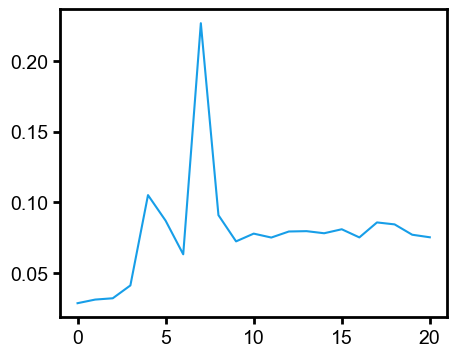

In [ ]:
# plot mutual information estimates
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.plot(mi_estimates)